Try the basic negative learning rule with threshold.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
%load_ext nengo.ipynb

from nengo_learn_assoc_mem.utils import gen_feed_func

<IPython.core.display.Javascript object>

In [2]:
dt = 0.001
seed = 0

ens_params = dict(encoders=[[1], [1], [-1], [-1]], intercepts=[-0.5, -0.1, -0.1, -0.5], max_rates=[250, 300, 300, 250])


def stim_func(t):
    if (t % 1) > 0.5:
        return 0.3
    else:
        return -0.3


lr = -5e-5
pre_nrn = 4

In [3]:
class FakeBCM(object):

    def __init__(self, learning_rate=1e-9, in_neurons=4, out_neurons=2, threshold=150,
                 sample_every=0.1, start_weights=None):
        self.kappa = learning_rate * dt
        assert start_weights is not None
        self.omega = start_weights.copy()
        self.in_nrns = in_neurons
        self.weight_history = []
        self.period = sample_every / dt
        self.thresh = threshold

    def bcm_func(self, t, x):
        in_rates = x[:self.in_nrns]
        out_rates = x[self.in_nrns:]
        in_rates[in_rates < self.thresh] = 0.
        self.omega += self.kappa * in_rates

        if (t / dt % self.period) < 1:
            self.weight_history.append(self.omega.copy())

        return np.dot(self.omega, in_rates)

# Try a polarising signal

In [4]:
with nengo.Network() as fake_model:
    sin = nengo.Node(stim_func)
    
    ens = nengo.Ensemble(pre_nrn, 1, **ens_params)

    fake_bcm = FakeBCM(in_neurons=pre_nrn, out_neurons=pre_nrn, learning_rate=lr, start_weights=np.zeros((4, 4)))
    learn = nengo.Node(fake_bcm.bcm_func, size_in=pre_nrn+pre_nrn, size_out=pre_nrn)

    nengo.Connection(sin, ens)

    nengo.Connection(ens.neurons, learn[:pre_nrn], synapse=0.01)
    nengo.Connection(ens.neurons, learn[pre_nrn:], synapse=0.01)
    nengo.Connection(learn, ens.neurons, synapse=None)

    fake_model.p_in = nengo.Probe(sin, synapse=None)
    fake_model.p_nd = nengo.Probe(learn, synapse=0.01)
    fake_model.p_out = nengo.Probe(ens, synapse=0.01)
    fake_model.p_spikes = nengo.Probe(ens.neurons, synapse=None)
    fake_model.p_rates = nengo.Probe(ens.neurons, synapse=0.005)
    fake_model.p_theta = nengo.Probe(ens.neurons, synapse=1.0)

In [5]:
sim_len = 20

with nengo.Simulator(fake_model) as fake_sim:
    fake_sim.run(sim_len)

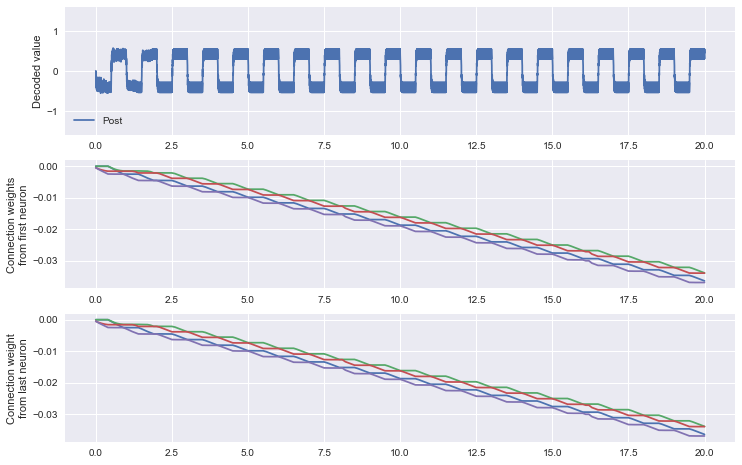

In [6]:
w_hist = np.array(fake_bcm.weight_history)
w_hist_trange = np.concatenate(([0], fake_sim.trange(dt=0.1),))

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(fake_sim.trange(), fake_sim.data[fake_model.p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(w_hist_trange, w_hist[:, 0])
plt.ylabel("Connection weights\nfrom first neuron")
plt.subplot(3, 1, 3)
plt.plot(w_hist_trange, w_hist[:, -1])
plt.ylabel("Connection weight\nfrom last neuron")

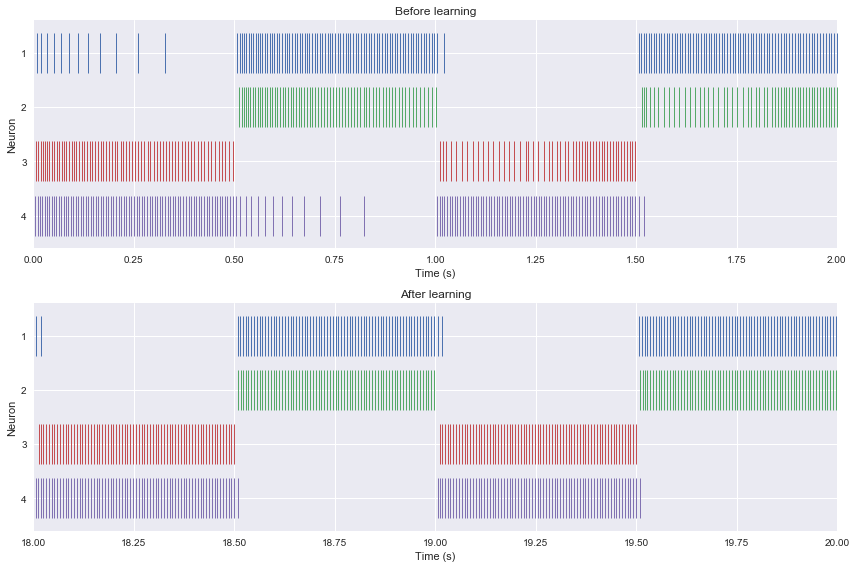

In [7]:
plt.figure(figsize=(12, 8))
win = int(2e3)

ax = plt.subplot(2, 1, 1)
rasterplot(fake_sim.trange()[:win], fake_sim.data[fake_model.p_spikes][:win], ax)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)')
ax.set_title('Before learning')

ax = plt.subplot(2, 1, 2)
rasterplot(fake_sim.trange()[-win:], fake_sim.data[fake_model.p_spikes][-win:], ax)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)')
ax.set_title('After learning')

plt.tight_layout()

In [8]:
tau_disp_filt = 0.01

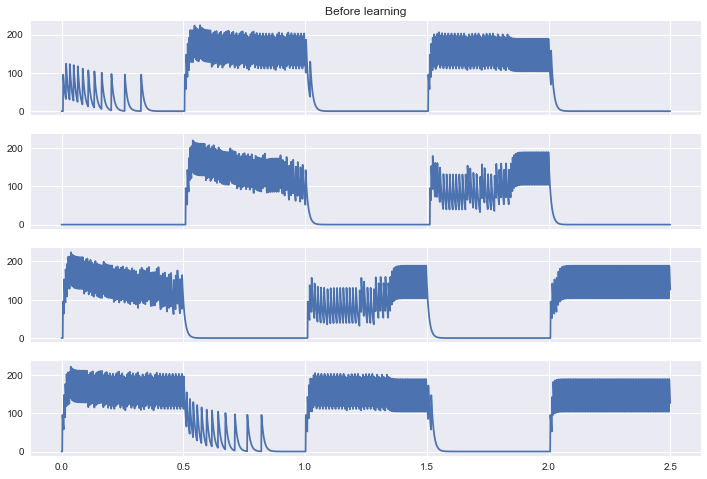

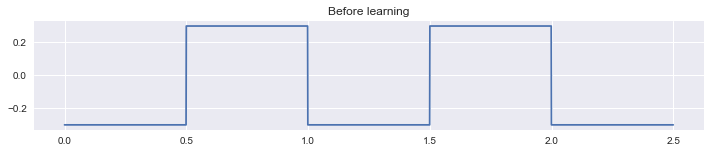

In [9]:
f, axes = plt.subplots(pre_nrn, sharex=True, sharey=True, figsize=(12, 8))
win = 2500
x_val = np.arange(0, win*dt, dt)

for nrn in range(pre_nrn):
    if nrn == 0:
        axes[nrn].set_title("Before learning")

    axes[nrn].plot(
        x_val,
        nengo.Lowpass(tau_disp_filt).filt(fake_sim.data[fake_model.p_spikes][:, nrn])[:win])

plt.figure(figsize=(12, 2))
plt.plot(x_val, fake_sim.data[fake_model.p_in][:win])
plt.title("Before learning")

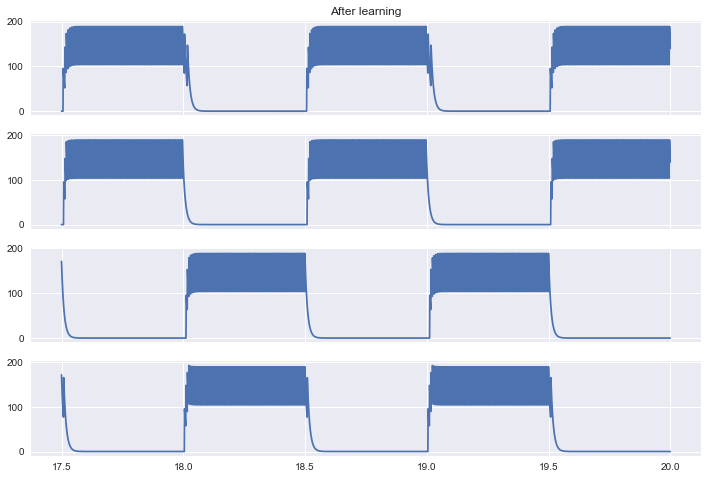

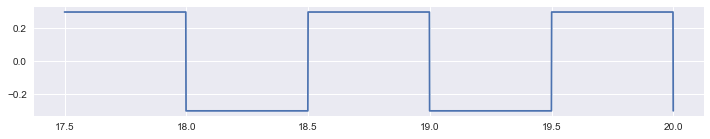

In [10]:
f, axes = plt.subplots(pre_nrn, sharex=True, sharey=True, figsize=(12, 8))
win = 2500
x_val = np.arange((sim_len - win*dt), sim_len, dt)

for nrn in range(pre_nrn):
    if nrn == 0:
        axes[nrn].set_title("After learning")

    axes[nrn].plot(
        x_val,
        nengo.Lowpass(tau_disp_filt).filt(fake_sim.data[fake_model.p_spikes][:, nrn])[-win:])

plt.figure(figsize=(12, 2))
plt.plot(x_val, fake_sim.data[fake_model.p_in][-win:])

# Try in an associative memory

In [11]:
from nengo import spa

from nengo_learn_assoc_mem.utils import BasicVecFeed

In [12]:
t_present = 0.3
t_pause = 0.1
dt = 0.001

dimensions = 32
n_neurons = 25

intercept = 0.1
seed = 8

In [13]:
rng = np.random.RandomState(seed=9)
vocab = spa.Vocabulary(dimensions, rng=rng)

for i in range(n_items):
    vocab.parse('X%d' % i)

items = list(range(n_items)) * n_present
random.shuffle(items)
vocab_items = ['X%d' % i for i in items]

NameError: name 'n_items' is not defined

In [8]:
class FakeAssocMem(nengo.Network):

    def __init__(self, n_neurons, dimensions, intercepts,
                 bcm_tau=0.005,
                 bcm_rate=-1e-3,
                 voja_tau=0.005,
                 voja_rate=1e-3,
                 pes_rate=1e-3,
                 seed=None,
                 ):

        super(FakeAssocMem, self).__init__()

        decoders = np.zeros((dimensions, n_neurons), dtype=float)

        self.seed = seed

        with self:
            self.input = nengo.Node(None, size_in=dimensions)
            self.output = nengo.Node(None, size_in=dimensions)
            self.correct = nengo.Node(None, size_in=dimensions)

            self.mem = nengo.Ensemble(n_neurons=n_neurons,
                                      dimensions=dimensions,
                                      intercepts=intercepts,
                                      max_rates=nengo.dists.Uniform(150,150),
                                      seed=seed)

            learning_rule_type = nengo.Voja(post_tau=voja_tau, learning_rate=voja_rate)
            self.conn_in = nengo.Connection(self.input, self.mem,
                                            learning_rule_type=learning_rule_type)

            self.fake_bcm = FakeBCM(in_neurons=n_neurons, out_neurons=n_neurons, learning_rate=bcm_rate,
                                   start_weights=np.zeros((n_neurons, n_neurons), dtype=float), threshold=110)
            learn = nengo.Node(self.fake_bcm.bcm_func, size_in=n_neurons*2, size_out=n_neurons)
            nengo.Connection(self.mem.neurons, learn[:n_neurons], synapse=0.005)
            nengo.Connection(self.mem.neurons, learn[n_neurons:], synapse=0.005)
            nengo.Connection(learn, self.mem.neurons, synapse=None)

            learning_rule_type = nengo.PES(learning_rate=pes_rate)
            self.conn_out = nengo.Connection(self.mem.neurons, self.output,
                                             transform=decoders,
                                             learning_rule_type=learning_rule_type)

            self.learn_control = nengo.Node(lambda t, x: x[:-1] if x[-1] < 0.5 else x[:-1] * 0,
                                            size_in=dimensions + 1)
            nengo.Connection(self.learn_control, self.conn_out.learning_rule)
            nengo.Connection(self.output, self.learn_control[:-1], synapse=None)
            nengo.Connection(self.correct, self.learn_control[:-1], transform=-1, synapse=None)

In [9]:
with nengo.Network() as train_model:
    stim = nengo.Node(gen_feed_func(vocab, vocab_items, t_present))
    correct = nengo.Node(gen_feed_func(vocab, vocab_items, t_present))

    mem = FakeAssocMem(n_neurons=n_neurons, dimensions=dimensions, intercepts=[intercept] * n_neurons)
    
    nengo.Connection(stim, mem.input, synapse=None)
    nengo.Connection(correct, mem.correct, synapse=None)
    
    p_out = nengo.Probe(mem.output, synapse=0.01)
    p_ideal = nengo.Probe(correct, synapse=0.01)
    
    p_dec = nengo.Probe(mem.conn_out, 'weights', sample_every=t_present/2)
    p_enc = nengo.Probe(mem.mem, 'scaled_encoders', sample_every=t_present/2)

In [10]:
with nengo.Simulator(train_model) as train_sim:
    train_sim.run(n_present*n_items*t_present)
    
enc = train_sim.data[p_enc][-1]
dec = train_sim.data[p_dec][-1]
rec = mem.fake_bcm.weight_history[-1]

A Jupyter Widget

A Jupyter Widget

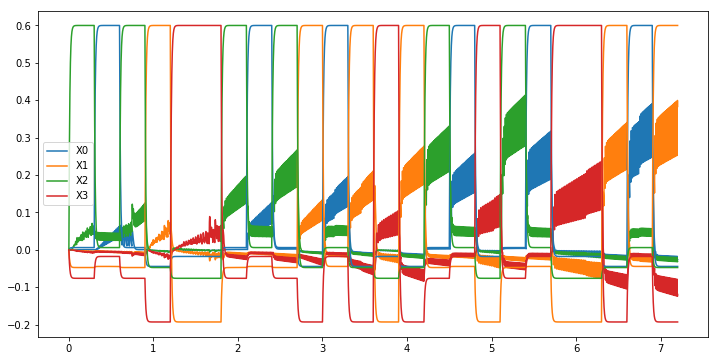

In [11]:
plt.figure(figsize=(12, 6))

plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_out], vocab))

plt.gca().set_prop_cycle(None)

plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_ideal], vocab)*0.6)

plt.legend(vocab.keys)

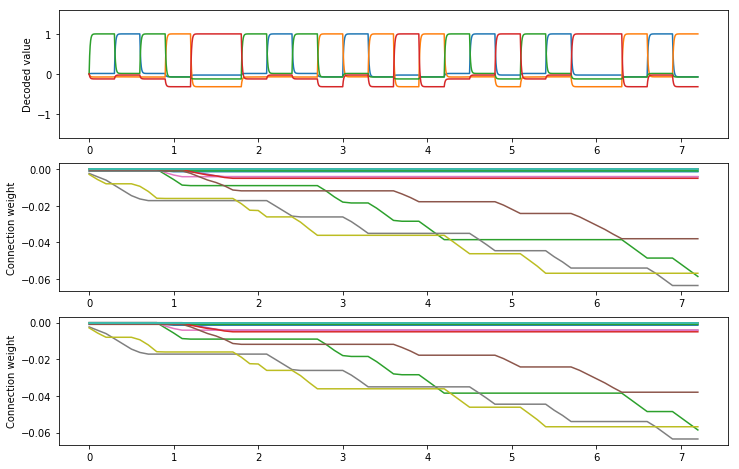

In [12]:
w_hist = np.array(mem.fake_bcm.weight_history)
w_hist_trange = np.concatenate(([0], train_sim.trange(dt=0.1),))

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_ideal], vocab))
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)

plt.subplot(3, 1, 2)
plt.plot(w_hist_trange, w_hist[:, 0])
plt.ylabel("Connection weight")
plt.subplot(3, 1, 3)
plt.plot(w_hist_trange, w_hist[:, 2])
plt.ylabel("Connection weight")

In [16]:
stim_func = gen_feed_func(vocab, vocab.keys, t_present)

In [13]:
with nengo.Network() as test_model:
    stim = nengo.Node(stim_func)
    correct = nengo.Node(gen_feed_func(vocab, vocab.keys, t_present))

    recall = nengo.Node(size_in=dimensions)

    test_mem = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                              encoders=enc,
                              intercepts=[intercept] * n_neurons)
    
    nengo.Connection(stim, test_mem, synapse=None)
    nengo.Connection(test_mem.neurons, recall, transform=dec)
    
    p_rec = nengo.Probe(recall, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)
    p_spikes = nengo.Probe(test_mem.neurons)

In [14]:
with nengo.Simulator(test_model) as test_sim:
    test_sim.run(n_items*t_present)

A Jupyter Widget

A Jupyter Widget

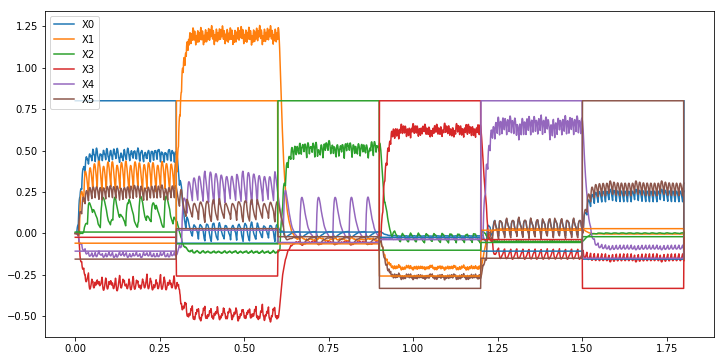

In [178]:
plt.figure(figsize=(12, 6))

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_rec], vocab))

plt.gca().set_prop_cycle(None)

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_cor], vocab)*0.8)

plt.legend(vocab.keys)

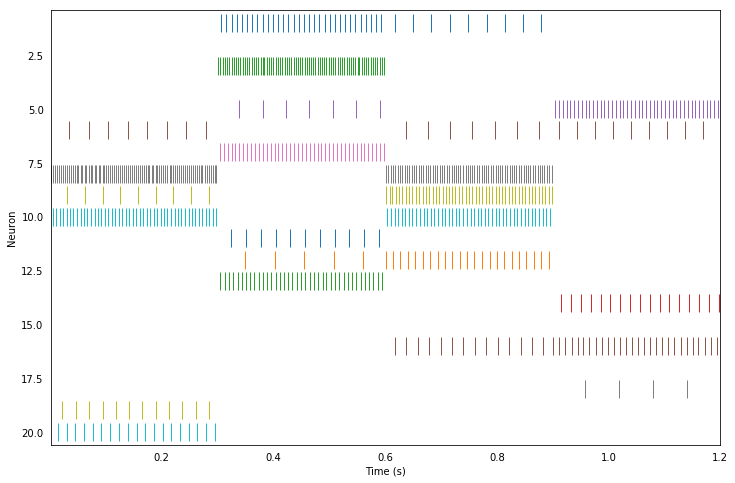

In [15]:
plt.figure(figsize=(12, 8))

ax = plt.subplot(1, 1, 1)
rasterplot(test_sim.trange(), test_sim.data[p_spikes], ax)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)');

In [27]:
def meg_from_spikes(spikes: np.ndarray, meg_syn=0.1):
    return nengo.Lowpass(meg_syn).filt(np.sum(spikes, axis=1))

## Test foil vs. target response

In [29]:
meg_filt = 0.1

In [33]:
foil = vocab.parse("FOIL")
stim_func = lambda t: foil

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(t_present)
    
foil_rate = meg_from_spikes(test_sim.data[p_spikes], meg_filt)

A Jupyter Widget

A Jupyter Widget

In [34]:
target = vocab.parse("X0")
stim_func = lambda t: target

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(t_present)
    
targ_rate = meg_from_spikes(test_sim.data[p_spikes], meg_filt)

A Jupyter Widget

A Jupyter Widget

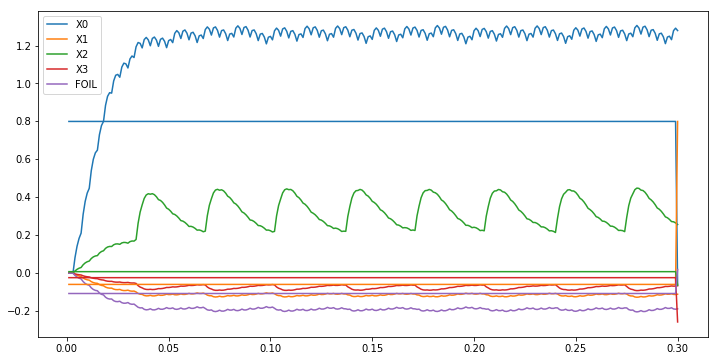

In [35]:
plt.figure(figsize=(12, 6))

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_rec], vocab))

plt.gca().set_prop_cycle(None)

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_cor], vocab)*0.8)

plt.legend(vocab.keys)

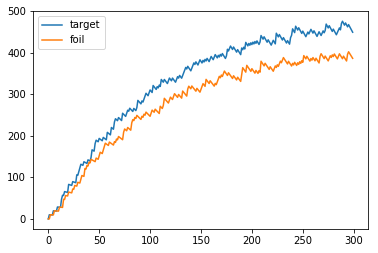

In [37]:
plt.plot(targ_rate, label="target")
plt.plot(foil_rate, label="foil")
plt.legend()

## Test fan1 vs fan2

In [16]:
rng = np.random.RandomState(seed=8)
vocab = spa.Vocabulary(dimensions, rng=rng)

fan1 = ["CAT+DOG", "DUCK+FISH", "HORSE+COW"]
fan1_vecs = []
fan1_labels = ["F11", "F12", "F13"]

fan2 = ["PIG+RAT", "PIG+GOAT", "SHEEP+EMU", "SHEEP+GOOSE"]
fan2_vecs = []
fan2_labels = ["F21", "F22", "F23", "F24"]

for vec in fan1:
    fan1_vecs.append(vocab.parse(vec).v)

for vec in fan2:
    fan2_vecs.append(vocab.parse(vec).v)

c:\users\mr_bo\git\nengo\nengo\spa\vocab.py:114: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=10)
  len(self.pointers)))


In [17]:
all_vecs = np.concatenate((fan1_vecs, fan2_vecs))
simi = np.dot(all_vecs, all_vecs.T)
np.fill_diagonal(simi, 0.)
intercept = np.ceil(np.max(simi)*100)/100
print(intercept)

0.8


In [84]:
np.unravel_index(np.argmax(simi), simi.shape)

(5, 6)

In [85]:
np.dot(all_vecs[5], all_vecs[6])

0.98658017477994464

In [92]:
print(spa.similarity(all_vecs[5], vocab))
print(spa.similarity(all_vecs[6], vocab))

[[-0.31807342  0.02933392 -0.1433166  -0.15583942 -0.23394427  0.00159698
  -0.1072615   0.08377864 -0.00760525  1.04613224  1.04613224 -0.05955207]]
[[-0.33846898  0.17181833 -0.12180608 -0.04167396 -0.38140097 -0.01523179
  -0.17547404  0.18056812 -0.17097243  0.95582501  0.03075517  0.95582501]]


In [90]:
vocab.keys

['CAT',
 'DOG',
 'DUCK',
 'FISH',
 'HORSE',
 'COW',
 'PIG',
 'RAT',
 'GOAT',
 'SHEEP',
 'EMU',
 'GOOSE']